# import

In [52]:
import pandas as pd
import numpy as np
import random
import os
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
# import torch.nn.functional as F # 비선형석 첨가
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

# Data 불러오기

In [53]:
train_df = pd.read_pickle('./processed_data/train_df.pkl')
test_df = pd.read_pickle('./processed_data/test_df.pkl')

display(train_df)
display(test_df)

,num_date_time,building_number,date_time,temperature,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,power_consumption
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.9,42.0,2022,6,1,0,2,152,20.584184,49.6576,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0,1085.28
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,1.1,45.0,2022,6,1,1,2,152,19.846954,47.7625,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0,1047.36
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,1.5,45.0,2022,6,1,2,2,152,19.317610,47.2225,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0,974.88
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,1.4,48.0,2022,6,1,3,2,152,18.337658,44.7856,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0,953.76
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,2.8,43.0,2022,6,1,4,2,152,19.585934,49.0061,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0,986.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.9,86.0,2022,8,24,19,2,236,25.094857,63.6624,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0,881.04
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,1.3,86.0,2022,8,24,20,2,236,24.244918,62.4024,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0,798.96
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,1.0,92.0,2022,8,24,21,2,236,23.241700,64.1976,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0,825.12
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.3,94.0,2022,8,24,22,2,236,23.472275,65.0744,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0,640.08


,num_date_time,building_number,date_time,temperature,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,2.2,72,2022,8,25,0,3,237,25.185563,58.3456,0,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.9,72,2022,8,25,1,3,237,24.994620,57.4456,0,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,1.5,75,2022,8,25,2,3,237,24.495488,57.8725,0,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,1.3,78,2022,8,25,3,3,237,23.937118,57.9376,0,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,1.0,77,2022,8,25,4,3,237,23.746200,56.9961,0,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100_20220831 19,100,2022-08-31 19:00:00,22.5,0.9,84,2022,8,31,19,2,243,24.493434,61.4824,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0
16796,100_20220831 20,100,2022-08-31 20:00:00,20.7,0.4,95,2022,8,31,20,2,243,23.067551,65.2725,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0
16797,100_20220831 21,100,2022-08-31 21:00:00,20.2,0.4,98,2022,8,31,21,2,243,22.590086,66.7056,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0
16798,100_20220831 22,100,2022-08-31 22:00:00,20.1,1.1,97,2022,8,31,22,2,243,21.978649,65.7281,0,Hotel_and_Resort,57497.84,40035.23,0.0,0.0,0.0


# Fixed Random Seed

In [54]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

# Hyperparameter Setting

In [55]:
# 하이퍼파라미터
input_size = 29  # feature의 개수
hidden_size = 64 # LSTM 레이어의 으닉 상태의 크기
num_layers = 2 # 학습 모델을 직렬 배치할 개수
output_size = 1 # 결과 값 형태
num_epochs = 5 # 학습 횟수
window_size = 24  # 예측에 사용될 시간 윈도우 크기, 예측을 위해 이전 몇개의 데이터 포인트를 참고할 것인가, 직전 24시간 데이터를 기반으로 다음 시간을 예측한다.
batch_size = 64 # 학습시 한번에 들어가는 input 데이터 개수 24 * 64개 가 한번에 학습 들어간다. batch_size가 커지면 기울기 업데이트 보편적인 학습이되고 업데이트 횟수는 줄어든다. 모델의 일반화 성능이 올라감
learning_rate = 0.001 

In [56]:
# input_size = len(['temperature', 'windspeed', 'humidity', 'year', 'month', 'day', 'hour', 'day_of_week', 'WCT', 'THI', 'holiday', 'total_area', 'cooling_area',
#               'solar_power_capacity', 'ess_capacity', 'pcs_capacity', 'building_type_Apartment', 'building_type_Commercial', 'building_type_Data_Center',
#               'building_type_Department_Store_and_Outlet', 'building_type_Discount_Mart', 'building_type_Hospital', 'building_type_Hotel_and_Resort',
#               'building_type_Knowledge_Industry_Center', 'building_type_Other_Buildings', 'building_type_Public', 'building_type_Research_Institute',
#               'building_type_University', 'power_consumption'])

# Dataset

In [57]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size

    def __len__(self): # row의 길이 반환
        return len(self.df) - self.window_size

    def __getitem__(self, idx): # dataset의 indexing
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        if self.df.shape[1] > 1:
            y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
        else:
            y = None
        return x, y

def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [58]:
# OneHotEncoder 객체 생성
encoder = OneHotEncoder()

# '색상' 컬럼을 원-핫 인코딩
encoded_data_train = encoder.fit_transform(train_df[['building_type']])
encoded_data_test = encoder.transform(test_df[['building_type']])

# 인코딩 결과를 데이터프레임으로 변환
df_encoded_train = pd.DataFrame(encoded_data_train.toarray(), columns=encoder.get_feature_names_out(['building_type']))
df_encoded_test = pd.DataFrame(encoded_data_test.toarray(), columns=encoder.get_feature_names_out(['building_type']))

train_df = pd.concat([train_df, df_encoded_train],axis=1)
test_df = pd.concat([test_df, df_encoded_test],axis=1)

temp = train_df.pop('power_consumption')
train_df['power_consumption'] = temp
train_df = train_df.drop(columns='building_type')
test_df = test_df.drop(columns='building_type')

train_df.columns, test_df.columns


(Index(['num_date_time', 'building_number', 'date_time', 'temperature',
        'windspeed', 'humidity', 'year', 'month', 'day', 'hour', 'day_of_week',
        'day_of_year', 'WCT', 'THI', 'holiday', 'total_area', 'cooling_area',
        'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
        'building_type_Apartment', 'building_type_Commercial',
        'building_type_Data_Center',
        'building_type_Department_Store_and_Outlet',
        'building_type_Discount_Mart', 'building_type_Hospital',
        'building_type_Hotel_and_Resort',
        'building_type_Knowledge_Industry_Center',
        'building_type_Other_Buildings', 'building_type_Public',
        'building_type_Research_Institute', 'building_type_University',
        'power_consumption'],
       dtype='object'),
 Index(['num_date_time', 'building_number', 'date_time', 'temperature',
        'windspeed', 'humidity', 'year', 'month', 'day', 'hour', 'day_of_week',
        'day_of_year', 'WCT', 'THI', 'holiday', 'tot

In [59]:
# normalization
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df.drop(['num_date_time', 'building_number', 'date_time', 'day_of_year'], axis=1).values)
train_loader = create_data_loader(train_data, window_size, batch_size)

# Model Define

In [60]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0)) # h : 은닉상태, c: 메모리셀 기억층(네부에서만 사용), # - 는 히드 스테이트 나오는거
        out = self.fc(out[:, -1, :]) 
        
        return out

In [61]:
# 맥 실리콘 사용을 위한 디바이스 이동
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 최적화 방식

current device: mps:0


# Train

In [62]:
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
            
print('==================== 학습 완료 ====================')

Epoch [1/5], Step [300/3188], Loss: 0.0005
Epoch [1/5], Step [600/3188], Loss: 0.0002
Epoch [1/5], Step [900/3188], Loss: 0.0002
Epoch [1/5], Step [1200/3188], Loss: 0.0028
Epoch [1/5], Step [1500/3188], Loss: 0.0156
Epoch [1/5], Step [1800/3188], Loss: 0.0018
Epoch [1/5], Step [2100/3188], Loss: 0.0000
Epoch [1/5], Step [2400/3188], Loss: 0.0000
Epoch [1/5], Step [2700/3188], Loss: 0.0003
Epoch [1/5], Step [3000/3188], Loss: 0.0035
Epoch [2/5], Step [300/3188], Loss: 0.0008
Epoch [2/5], Step [600/3188], Loss: 0.0002
Epoch [2/5], Step [900/3188], Loss: 0.0009
Epoch [2/5], Step [1200/3188], Loss: 0.0023
Epoch [2/5], Step [1500/3188], Loss: 0.0227
Epoch [2/5], Step [1800/3188], Loss: 0.0029
Epoch [2/5], Step [2100/3188], Loss: 0.0000
Epoch [2/5], Step [2400/3188], Loss: 0.0000
Epoch [2/5], Step [2700/3188], Loss: 0.0002
Epoch [2/5], Step [3000/3188], Loss: 0.0036
Epoch [3/5], Step [300/3188], Loss: 0.0015
Epoch [3/5], Step [600/3188], Loss: 0.0003
Epoch [3/5], Step [900/3188], Loss: 0.00

# Test Data Pre-processing

In [63]:
# 학습 데이터에서 마지막 행 가져오기
last_train_data = train_df.drop(['num_date_time', 'building_number', 'date_time', 'day_of_year'], axis=1).loc[204000-24:,:]

# 전력소비량 열 생성
final_df = pd.concat((test_df.drop(['num_date_time', 'building_number', 'date_time', 'day_of_year'], axis=1), pd.DataFrame(np.zeros(test_df.shape[0]))),axis=1)
final_df = final_df.rename({0:'power_consumption'},axis=1)

# Test Dataset

In [64]:
test_df = pd.concat((last_train_data, final_df)).reset_index(drop=True)
test_data = scaler.transform(test_df.values) # train과 동일하게 scaling
test_data.shape

(16824, 29)

In [65]:
# Dataset & DataLoader
test_dataset = TimeSeriesDataset(test_data, window_size)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Inference

In [71]:
model.eval()

test_predictions = []

with torch.no_grad():
    for i in tqdm(range(test_data.shape[0] - window_size)):
        x = torch.Tensor(test_data[i:i+window_size,:]).to(device)
        new_x = model(x.view(1,window_size,-1))
        
        test_data[i+window_size,-1] = new_x # 입력 업데이트
        test_predictions.append(new_x.detach().cpu().numpy().item()) # 예측 결과 저장

100%|███████████████████████████████████████| 16800/16800 [00:36<00:00, 459.74it/s]


# Submit

In [67]:
predictions = scaler.inverse_transform(test_data)[24:,-1] # 원래 scale로 복구

In [68]:
sample_submission = pd.read_csv('./input/sample_submission.csv')

In [69]:
sample_submission['answer'] = predictions
sample_submission.head()

,num_date_time,answer
0,1_20220825 00,701.991132
1,1_20220825 01,653.357874
2,1_20220825 02,587.541208
3,1_20220825 03,612.513977
4,1_20220825 04,688.281627


In [70]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M%S")
sample_submission.to_csv(f'./result/{formatted_time}_lstm_baseline_submission.csv', index=False)

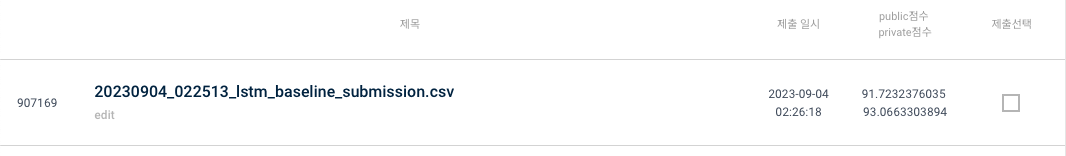